In [1]:
import dgl
from dgl.data import TreeGridDataset
import torch
import torch_geometric
import torch_geometric.transforms as T

In [2]:
import argparse
import time
import easydict
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch_geometric.utils
from torch_geometric.utils.convert import from_networkx
from torch_geometric.logging import log
import os
import pandas as pd
import glob
import pickle

In [4]:
dataset = TreeGridDataset()
g = dataset[0]

Done loading data from cached files.


In [5]:
#Download file Tree_Grids.pkl from the dataset in https://github.com/Graph-and-Geometric-Learning/D4Explainer. Tree_Grids.pkl is required for the train/val/test splits.

In [6]:
with open('Tree_Grids.pkl', 'rb') as fin:
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, edge_label_matrix  = pickle.load(fin)

In [7]:
len(adj)

1231

In [8]:
g.ndata["train_mask"] = torch.tensor(train_mask)
g.ndata["val_mask"] = torch.tensor(val_mask)
g.ndata["test_mask"] = torch.tensor(test_mask)

In [9]:
data = torch_geometric.utils.from_dgl(g)
data.x = data.feat
data.y = data.label
data.pop('feat')
data.pop('__orig__')
data.pop('label')
#data

tensor([1, 1, 1,  ..., 0, 0, 0])

In [10]:
x = torch.tensor([1.0]*10)
data.x = x.repeat(data.x.shape[0],1)

In [11]:
data.x

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [12]:
data

Data(edge_index=[2, 1705], train_mask=[1231], val_mask=[1231], test_mask=[1231], x=[1231, 10], y=[1231])

In [13]:
parser = argparse.ArgumentParser()
args = easydict.EasyDict({
    "dataset": 'TreeGrid',
    #"batch_size": 128,
    # "hidden_channels": 64,
    # "lr": 0.0005,
    "epochs": 2000,
})

In [14]:
device = 'cpu'
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             )
        self.conv2 = GCNConv(hidden_channels, hidden_channels,
                             )
        self.conv3 = GCNConv(hidden_channels, out_channels,
                             )

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [15]:
def evaluate_gnn(graph):
    with torch.no_grad():
        model.eval()
        graph = graph.to(device)
        # The pred is not used for accuracy, the softmax is used
        out = model(graph.x.float(), graph.edge_index, graph.batch)
        pred = out.argmax(dim=-1)

        # Getting class prediction probabilities from the softmax layer
        softmax = out.softmax(dim=-1)

        return softmax.tolist()

In [16]:
graphs_path = '../../graph generator/diffusion models/sampled_graphs_diffusion/' 
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'TreeGrid_10to15/*.gexf')]))

Original no of graphs: 1196


In [17]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
class_graphid_list = []

In [18]:
def get_max_pred(softmax_dict,i):
    #Getting the list of predictions for each class
    prob_class0_dict = {}
    prob_class1_dict = {}

    for nodeid in softmax_dict:
        list0= []
        list1= []
 
        if len(softmax_dict[nodeid]) > 0:
            list0= []
            list1= []

    
            for prob in softmax_dict[nodeid]:        
                list0.append(prob[0])        
                list1.append(prob[1]) 
     
    
         #Taking max probability of all nodes of each class in a graph
        if len(list0) != 0:
            prob_class0_dict[nodeid]=max(list0)
        if len(list1) != 0:    
            prob_class1_dict[nodeid]=max(list1)


    max_pred0 = max(prob_class0_dict.values())
    max_pred1 = max(prob_class1_dict.values())


    print('Run'+str(i), max_pred0, max_pred1)
    max_pred_list.append([max_pred0, max_pred1])

    graph_dict_list.append(graph_dict)
    softmax_dict_list.append(softmax_dict)
    
    avg_max_pred = (max_pred0+max_pred1)/2
    avg_max_pred_list.append(avg_max_pred)
    
    class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
    class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)


    class_graphid_list.append([class0_graphid,class1_graphid])

In [19]:
for i in range(0,10):
    device = 'cpu'
    model = GCN(
        in_channels=data.x.shape[1],
        hidden_channels=64,
        out_channels=2,
    ).to(device)
    
    optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0),
    dict(params=model.conv3.parameters(), weight_decay=0)
    ], lr=0.005)  # Only perform weight-decay on first convolution.

    best_val_acc = test_acc = 0
    start_patience = patience = 100
    #times = []
    for epoch in range(1, 2000 + 1):
        loss = train()
        train_acc, val_acc, tmp_test_acc = test()
        if val_acc > best_val_acc:
            test_acc = tmp_test_acc
        if epoch%100==0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
        #times.append(time.time() - start)
    
        if (val_acc>best_val_acc):
            patience = start_patience
            best_val_acc = val_acc
    
        else:
            patience -= 1
            
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break 

    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}

    for filepath in glob.iglob(graphs_path + 'TreeGrid_10to15/*.gexf'):
    
        graph = nx.read_gexf(filepath)
    
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]

        small_graph = from_networkx(graph)
        #x = torch.tensor([1.0,0.0])
        x = torch.tensor([1.0]*10)
        small_graph.x= x.repeat(small_graph.num_nodes,1)
        small_graph.y = small_graph.pop('node_type')
        transform=T.Constant(node_types='conference')
        small_graph = transform(small_graph)
        transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
        small_graph = transform(small_graph)
    
        small_graph.pop('mode')
        small_graph.pop('weight')
        small_graph.pop('label')
        small_graph.pop('id')
        small_graph.pop('num_nodes')
        #print(small_graph)
        
        softmax = evaluate_gnn(small_graph)
        softmax_dict[graph_id] = softmax
        graph_dict[graph_id]=graph

    print("No. of graphs evaluated: ",len(softmax_dict))
    get_max_pred(softmax_dict,i)


Epoch: 100, Loss: 0.6320, Train: 0.4248, Val: 0.3821, Test: 0.7500
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1196
Run0 0.6606975197792053 0.35886600613594055
Epoch: 100, Loss: 0.6347, Train: 0.4248, Val: 0.3821, Test: 0.7500
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1196
Run1 0.6290929913520813 0.3820337653160095
Epoch: 100, Loss: 0.6429, Train: 0.4248, Val: 0.3821, Test: 0.6371
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1196
Run2 0.6077994704246521 0.4006652235984802
Epoch: 100, Loss: 0.6263, Train: 0.4248, Val: 0.3821, Test: 0.7500
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1196
Run3 0.6784277558326721 0.34692198038101196
Epoch: 100, Loss: 0.6279, Train: 0.4248, Val: 0.3821, Test: 0.7500
Stopping training as validation accuracy did not improve for 100 epochs
No. of 

In [20]:
avg_max_pred_list

[0.5097817629575729,
 0.5055633783340454,
 0.5042323470115662,
 0.512674868106842,
 0.503477469086647,
 0.5093445330858231,
 0.5040641874074936,
 0.509448766708374,
 0.5114838778972626,
 0.5072386860847473]

In [21]:
np.mean(avg_max_pred_list)

0.5077309876680374

In [22]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

3

In [23]:
class_graphid_list

[['graph1182', 'graph855'],
 ['graph811', 'graph855'],
 ['graph1016', 'graph855'],
 ['graph1182', 'graph855'],
 ['graph54', 'graph225'],
 ['graph1109', 'graph477'],
 ['graph911', 'graph225'],
 ['graph1109', 'graph245'],
 ['graph1016', 'graph477'],
 ['graph54', 'graph477']]

In [24]:
def plot_graph(graphid, max_pred, nodetype):
    
    graph=nx.read_gexf(graphs_path + 'TreeGrid_10to15/' + graphid + '.gexf')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False,
             node_size=100)
    plt.show()

In [25]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]

In [26]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]

Number of nodes:  15
graph id:  graph1182
Max pred probability for class 0 is 0.6784277558326721


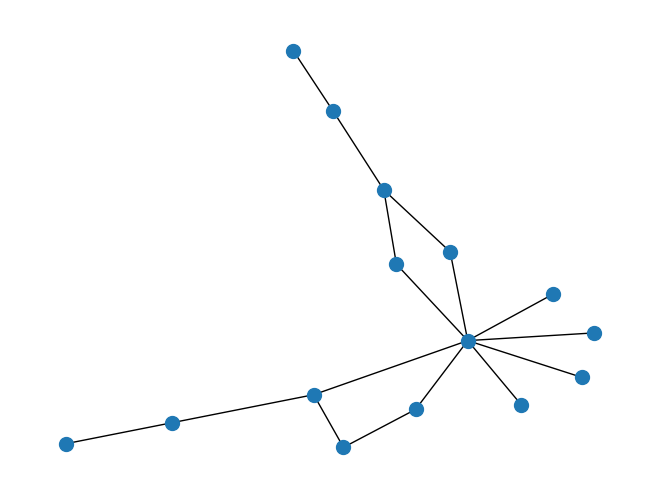

In [27]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0)

Number of nodes:  14
graph id:  graph855
Max pred probability for class 1 is 0.34692198038101196


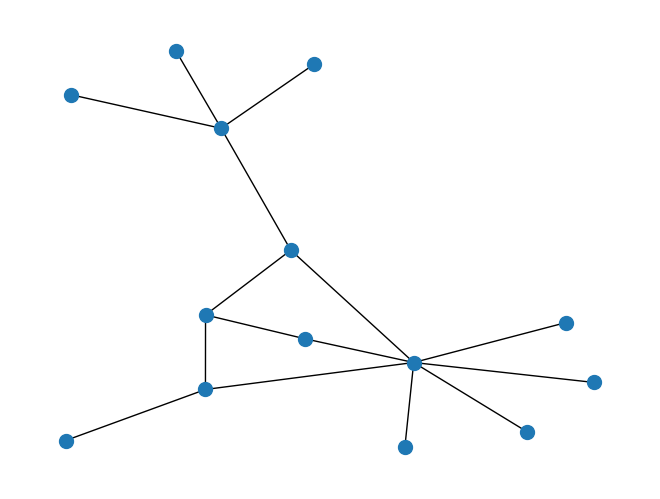

In [28]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1)

In [29]:
motifs_path = '../motifs/TreeGrids/'
files_motif = os.listdir(motifs_path)

In [ ]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

In [31]:
def get_faithfulness(graphid_list):
    class_faithfulness = []
    for graphid in graphid_list:
        expln_graph=nx.read_gexf(graphs_path + 'TreeGrid_10to15/' + graphid + '.gexf')
        
        faith_score_list = []
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(motifs_path, file_m)
            
            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            faith_score_list.append(x)

        class_faithfulness.append(np.mean(faith_score_list))

    return np.mean(class_faithfulness)

In [32]:
faithfulness_list = []

for i in range(0,10):
    faithfulness = get_faithfulness(class_graphid_list[i])

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print(np.mean(faithfulness_list))

Run0 1.0
Run1 1.0
Run2 1.0
Run3 1.0
Run4 0.6333333333333333
Run5 1.0
Run6 0.6666666666666666
Run7 0.6666666666666666
Run8 1.0
Run9 0.9666666666666667
0.8933333333333333
